https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/data - Датасет с kaggle
https://archive.ics.uci.edu/dataset/45/heart+disease - Оригинальный датасет с описанием всей информации

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score,f1_score,log_loss,accuracy_score, classification_report


In [3]:
heart = pd.read_csv("dataset/heart.csv")

* age : Возраст пациента

* sex : Пол пациента | 0 - Женский | 1 - Мужской

* exng : стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)

* caa: количество крупных сосудов (0-3)

* cp: Тип боли в груди
    * Значение 1: типичная стенокардия
    * Значение 2: атипичная стенокардия
    * Значение 3: боль, не связанная со стенокардией
    * Значение 0: бессимптомная.

* trtbps : артериальное давление в состоянии покоя (в мм рт.ст.)

* chol: уровень холестерина в мг/дл определяется с помощью датчика ИМ

* fbs : (уровень сахара в крови натощак > 120 мг/дл) (1 = верно; 0 = неверно)

* rest_ecg : результаты электрокардиографии в состоянии покоя

    * Значение 0: в норме
    * Значение 1: аномалия зубца ST-T (инверсия зубца T и/или подъем или спад сегмента ST > 0,05 мВ)
    * Значение 2: указывает на вероятную или определенную гипертрофию левого желудочка по критериям Эстеса.

* thal - 2 = нормальный; 1 = исправленный дефект; 3 = устраняемый дефект

* thalachh : достигнута максимальная частота сердечных сокращений

* oldpeak : Депрессия ST, вызванная физической нагрузкой, по сравнению с отдыхом

* slope: наклон максимального сегмента ST упражнения
    * Значение 2: Восходящая
    * Значение 1: Горизонтальная
    * Значение 0: Нисходящая

* output : : 0 = меньше шансов на сердечный приступ, 1 = больше шансов на сердечный приступ.

`Вся информация была взята из источников описанных выше`
`Перевод машинный`

# Визуализация данных

In [4]:
unique_values = {col: heart[col].value_counts().count() for col in heart.columns}
df_uniq = pd.DataFrame(unique_values.values(),index = unique_values.keys(),columns=["Кол-во уникальных значения"]) 

In [5]:
df_uniq

Кол-во уникальных значения
age                               41
sex                                2
cp                                 4
trtbps                            49
chol                             152
fbs                                2
restecg                            3
thalachh                          91
exng                               2
oldpeak                           40
slp                                3
caa                                5
thall                              4
output                             2

Выведем информацию о пациентах.
 

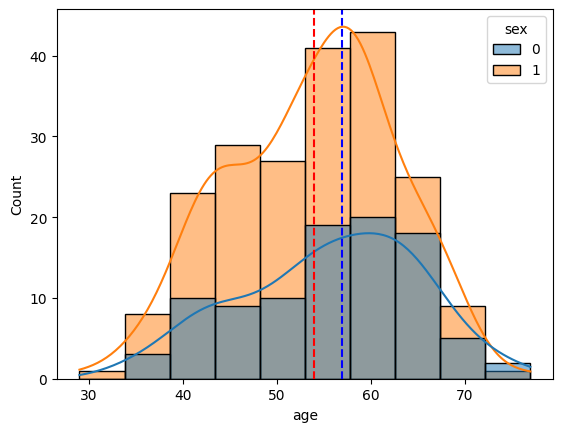

Кол-во пациентов женщин : 96
Кол-во пациентов мужчин : 207


In [6]:
"""
Узнаем о медианном показателе возраста для Мужчин и Женщин
"""
sns.histplot(x = 'age', hue = 'sex', data = heart, bins =10,kde=True)
plt.axvline(x=heart[heart["sex"]==0]['age'].median(), color='blue', linestyle='--', label='Median')
plt.axvline(x=heart[heart["sex"]==1]['age'].median(), color='red', linestyle='--', label='Median')
plt.show()
print("Кол-во пациентов женщин :",heart[heart["sex"]==0]["sex"].count())
print("Кол-во пациентов мужчин :",heart[heart["sex"]==1]["sex"].count())

`
Выделям категориальные данные, для дальнейшего анализа зависимости каждого столбца с целевой переменной output`

`И описываем для более читаемого вывода значеий в графики`


In [7]:

categorical_value = ["sex","exng","caa","fbs","restecg","thall","slp","cp"]
description_val = {"sex":{0:"Женский",1:"Мужской"},
                   "exng":{0:"Стенокардия физ. нагруз. - нет",1:"Стенокардия физ. нагруз. - да"},
                   "caa":{0:"круп. сосуды : 0",1:"круп. сосуды : 1",2:"круп. сосуды : 2",3:"круп. сосуды : 3",4:"круп. сосуды : 4"},
                   "fbs":{0:"Сахар > 120 мг - 0",1:"Сахар > 120 мг - 1"},
                   "restecg":{0:"В норма",1:"Аномалия зубца ST-T",2:"гипертрофию левого желудочка по критериям Эстеса"},
                   "thall":{0:"Неизвестно",1:"исправленный дефект",2:"нормальный",3:"устраняемый дефект"},
                   "slp":{0:"Нисходящая",1:"Горизонтальная",2:"Восходящая"},
                   "cp":{0:"бессимптомная",1:"типичная стенокардия",2:"атипичная стенокардия",3:"боль, не связанная со стенокардией"}}

`Выводим графики для каждого категориального столбца зависимости от целевой переменной библиотекой plotly`

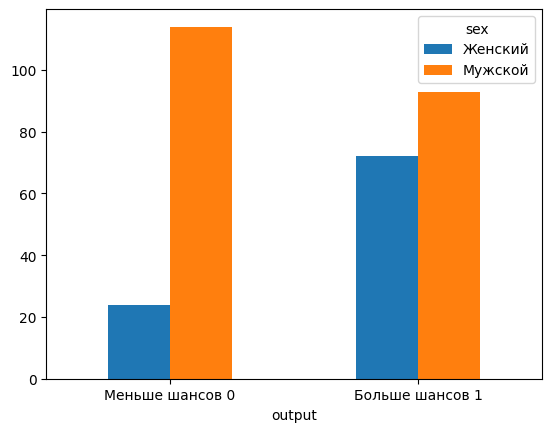

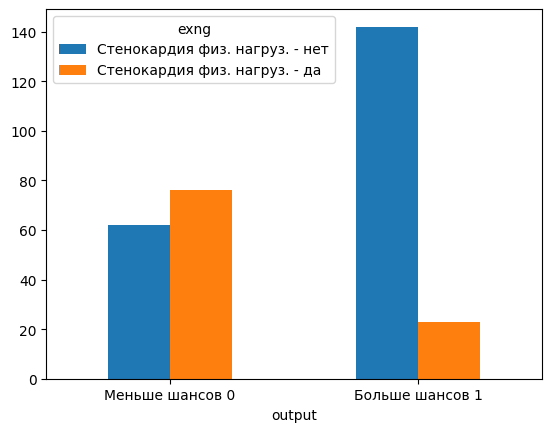

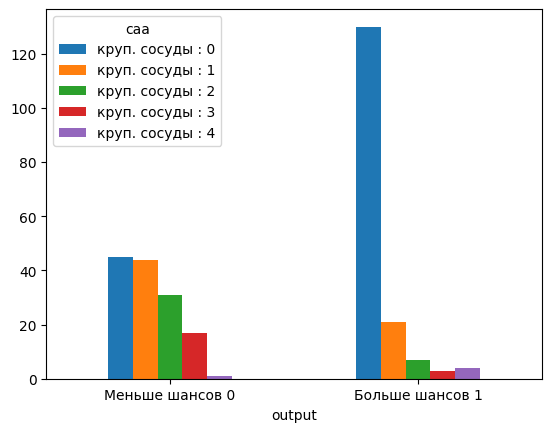

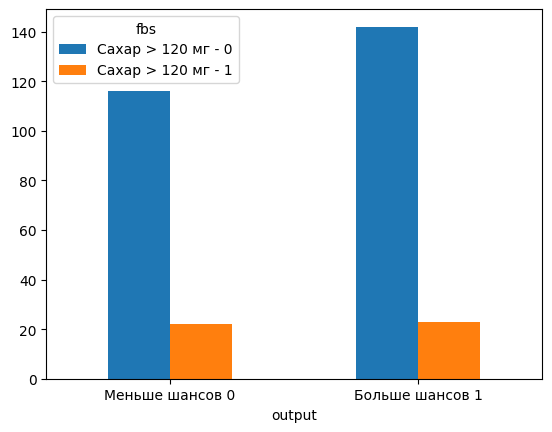

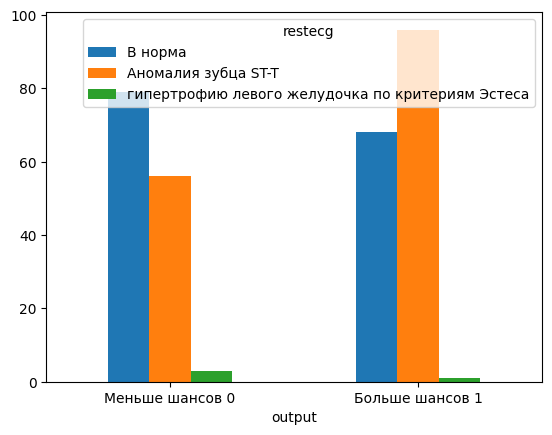

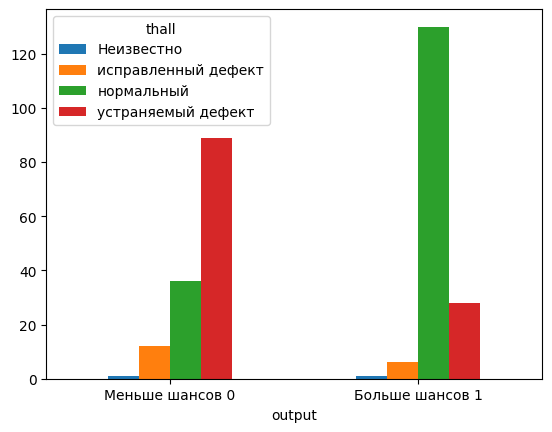

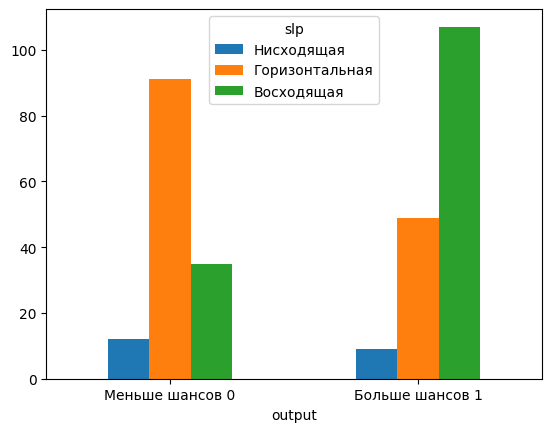

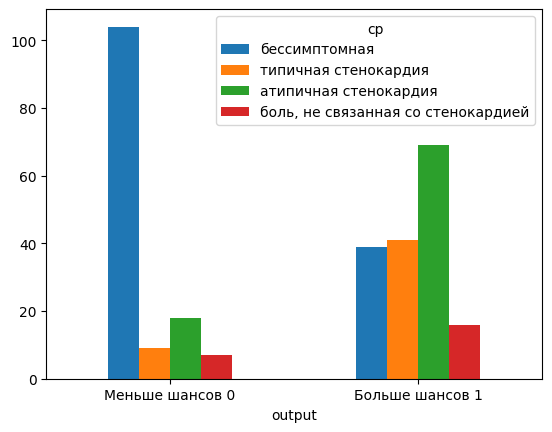

In [8]:
# cross_tab = pd.crosstab(index=heart["output"], columns=[heart[categorical_value[i]].value_counts() for i in range(len(categorical_value))])
for i in categorical_value:
    cross_tab = pd.crosstab(index=heart["output"], columns=heart[i])
    cross_tab.columns = cross_tab.columns.map(description_val[i])
    cross_tab.index = cross_tab.index.map({0:"Меньше шансов 0",1:"Больше шансов 1"})
    cross_tab.plot.bar(rot = 0)

`Выводим графики для каждого категориального столбца зависимости от целевой переменной только через библиотеку seaborn`

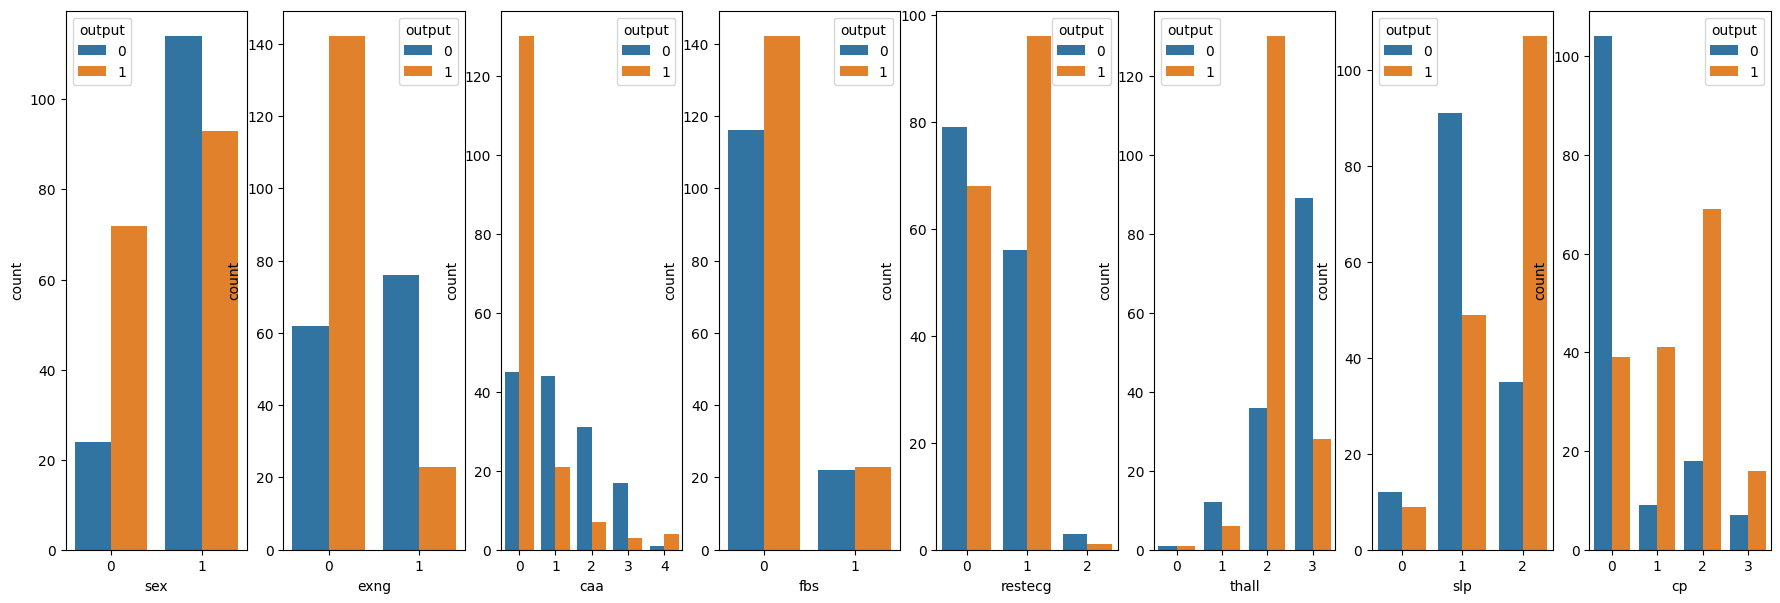

In [9]:
# # g = sns.FacetGrid(data=heart,col_wrap=5,row_order=["sex","exng","caa","fbs","restecg"],height=4,col="output")
fig, ax = plt.subplots(1,len(categorical_value),figsize=(22,7))
for enum,i in enumerate(categorical_value):
    # g.map(sns.countplot,i)
    sns.countplot(data=heart, x=i,hue="output",ax=ax[enum])
    # plt.show()

In [10]:
Numeric_values = heart.columns.difference(["output"]+categorical_value)

`Поиск зависимости целевой переменой от числовых значений`

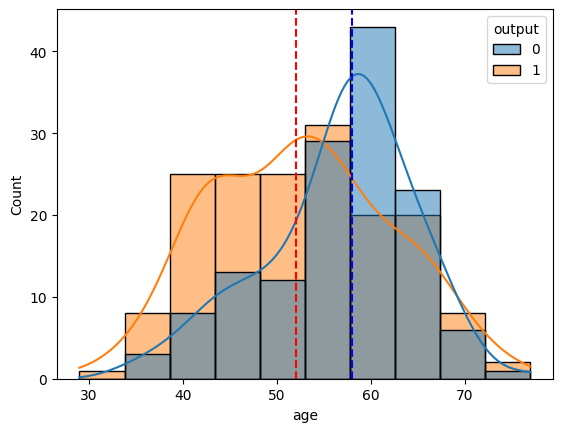

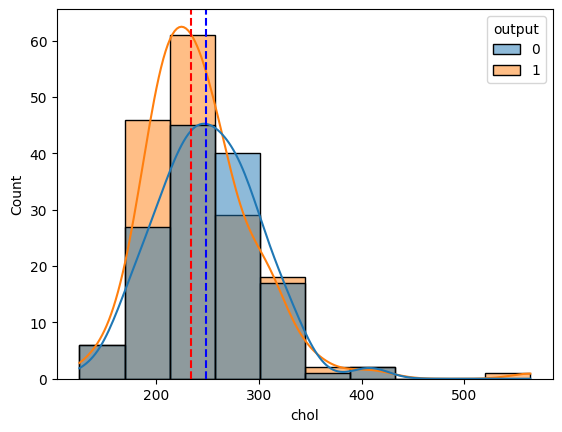

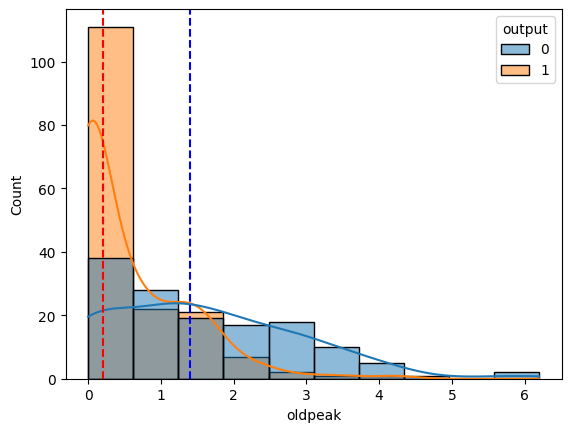

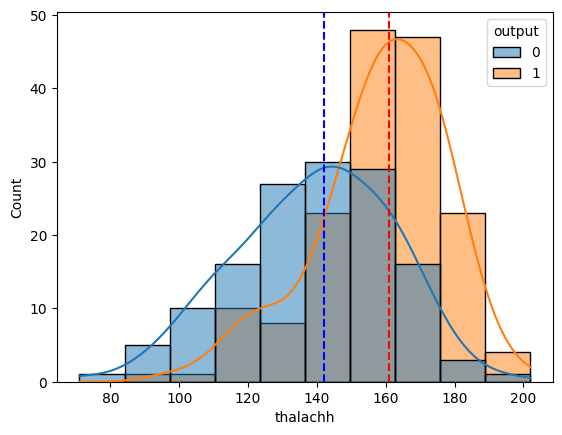

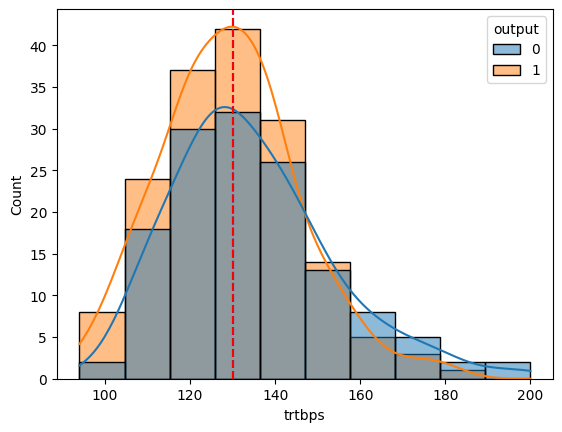

In [11]:
for i in Numeric_values:
    sns.histplot(x = i, hue = 'output', data = heart, bins =10,kde=True)
    plt.axvline(x=heart[heart["output"]==0][i].median(), color='blue', linestyle='--', label='Median')
    plt.axvline(x=heart[heart["output"]==1][i].median(), color='red', linestyle='--', label='Median')
    plt.show()

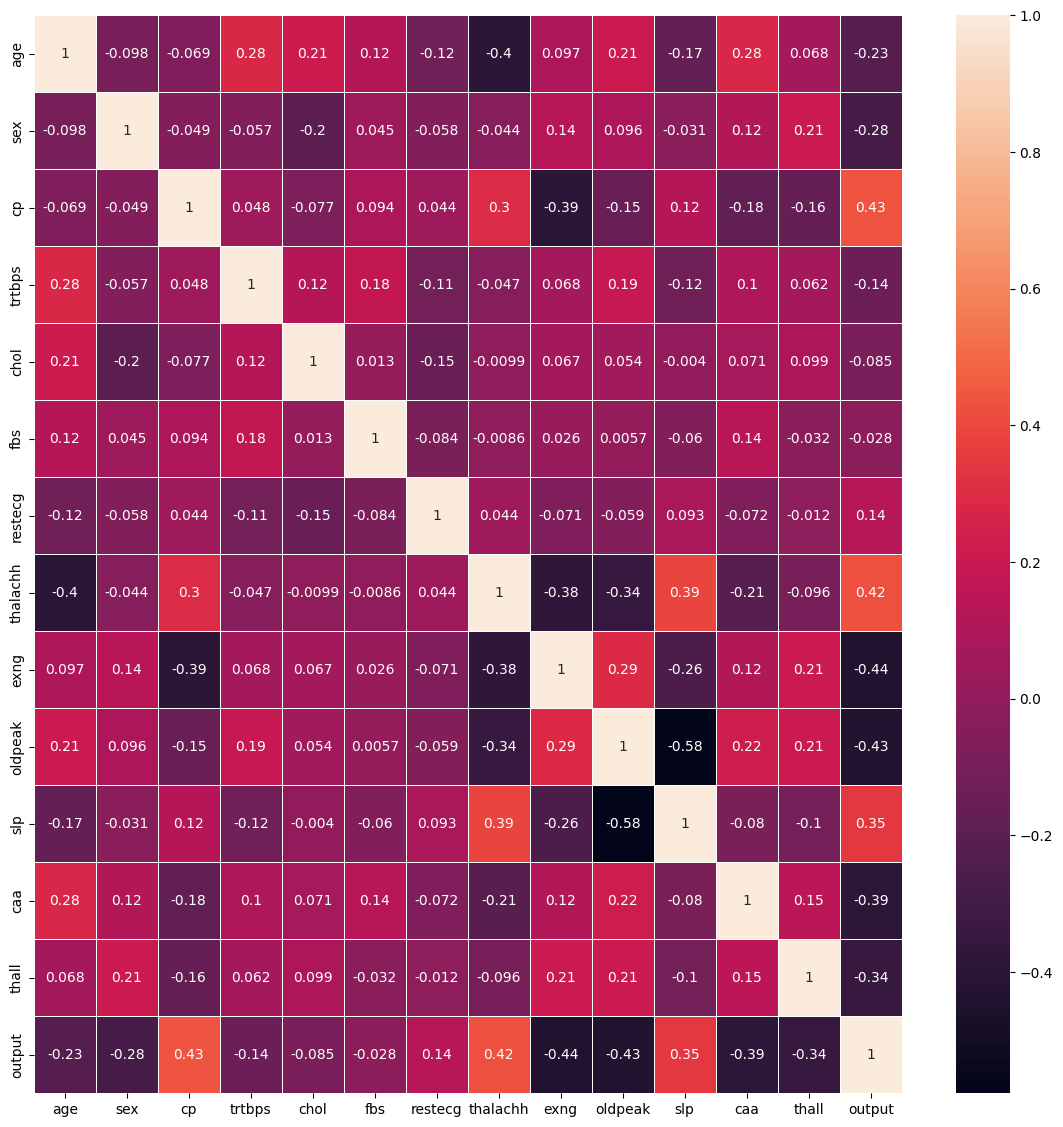

In [12]:
plt.figure(figsize=(14,14))
sns.heatmap(heart.corr(),annot = True, linewidths = 0.5)
plt.show()

# Создание датасета

In [13]:
train = heart.sample(frac=0.8,random_state=15)
test = heart.drop(train.index)

In [14]:
remove_importance = []

In [15]:
train_x = train[train.columns.difference(["output"]+remove_importance)]
train_y = train["output"]
print(train_y.value_counts())
test_x = test[train.columns.difference(["output"]+remove_importance)]
test_y = test["output"]
print(test_y.value_counts())

1    129
0    113
Name: output, dtype: int64
1    36
0    25
Name: output, dtype: int64


In [16]:
print(train_x["sex"].value_counts())
print(test_x["sex"].value_counts())

1    167
0     75
Name: sex, dtype: int64
1    40
0    21
Name: sex, dtype: int64


`Создаём новый список категориальных значений, удаляя признаки для эксперемента`

In [17]:
new_categorical = [i for i in categorical_value if i not in remove_importance]

# Обучение

In [18]:
arg = {"iterations":850,"learning_rate":0.005,"depth":3,"reg_lambda":10,"leaf_estimation_method":"Newton","random_seed":1,"loss_function":"Logloss"}
catboost_classifier = catboost.CatBoostClassifier(**arg)

In [19]:
catboost_classifier.fit(X=train_x,y=train_y,cat_features=new_categorical,eval_set=(test_x,test_y))

0:	learn: 0.6910463	test: 0.6914220	best: 0.6914220 (0)	total: 174ms	remaining: 2m 27s
1:	learn: 0.6894419	test: 0.6900674	best: 0.6900674 (1)	total: 181ms	remaining: 1m 16s
2:	learn: 0.6868011	test: 0.6880803	best: 0.6880803 (2)	total: 190ms	remaining: 53.7s
3:	learn: 0.6840556	test: 0.6847826	best: 0.6847826 (3)	total: 198ms	remaining: 41.8s
4:	learn: 0.6816321	test: 0.6822259	best: 0.6822259 (4)	total: 206ms	remaining: 34.8s
5:	learn: 0.6782517	test: 0.6784630	best: 0.6784630 (5)	total: 214ms	remaining: 30s
6:	learn: 0.6761404	test: 0.6767241	best: 0.6767241 (6)	total: 220ms	remaining: 26.5s
7:	learn: 0.6738497	test: 0.6742042	best: 0.6742042 (7)	total: 229ms	remaining: 24.1s
8:	learn: 0.6712808	test: 0.6714642	best: 0.6714642 (8)	total: 236ms	remaining: 22s
9:	learn: 0.6687151	test: 0.6689888	best: 0.6689888 (9)	total: 243ms	remaining: 20.4s
10:	learn: 0.6657117	test: 0.6656022	best: 0.6656022 (10)	total: 250ms	remaining: 19.1s
11:	learn: 0.6643850	test: 0.6644596	best: 0.6644596 (

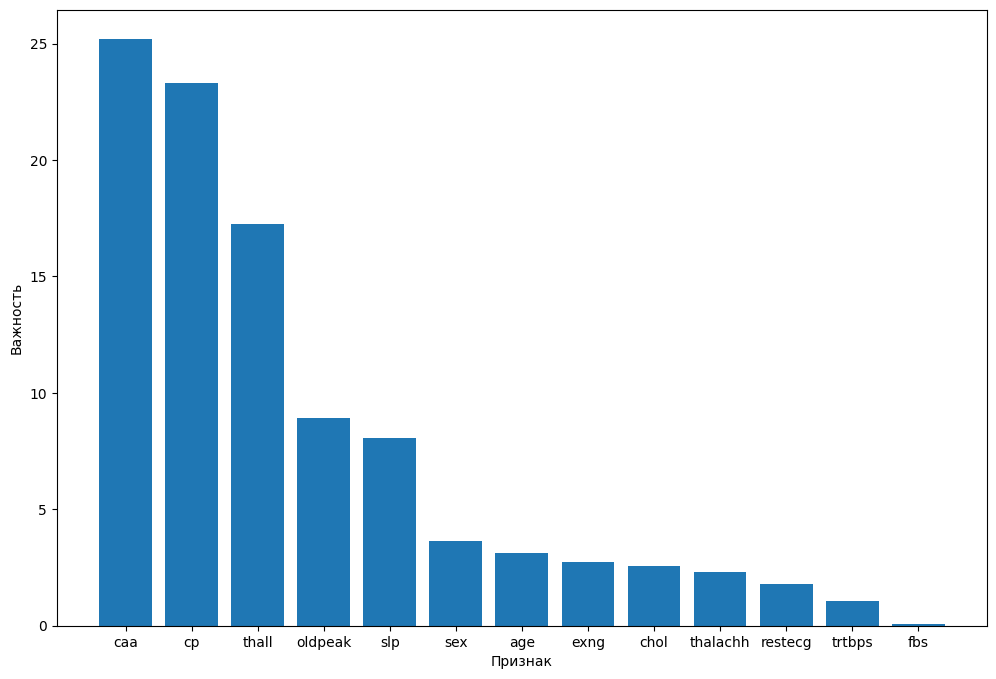

In [20]:
feature_importance = catboost_classifier.get_feature_importance()

importance_df = pd.DataFrame({'Признак': train_x.columns, 'Важность': feature_importance})

sorted_importance = importance_df.sort_values(by='Важность', ascending=False)

plt.figure(figsize=(12,8))
plt.bar(sorted_importance['Признак'], sorted_importance['Важность'])

plt.xlabel("Признак")
plt.ylabel("Важность")

plt.show()

In [21]:
predict = catboost_classifier.predict(test_x)

In [22]:
print("f1_score",f1_score(test_y,predict))
print("roc_auc_score",roc_auc_score(test_y,predict))
list_true_val = 0
for enum,i in enumerate(predict):
    if i == test_y.iloc[enum]:
        list_true_val += 1
print(list_true_val/len(predict))
print("Верных значений",list_true_val, "Всего значений",len(test_y))
print("accuracy",classification_report(test_y,predict))

f1_score 0.918918918918919
roc_auc_score 0.8922222222222222
0.9016393442622951
Верных значений 55 Всего значений 61
accuracy               precision    recall  f1-score   support

           0       0.91      0.84      0.87        25
           1       0.89      0.94      0.92        36

    accuracy                           0.90        61
   macro avg       0.90      0.89      0.90        61
weighted avg       0.90      0.90      0.90        61



# Автоматический перебор гиперпараметров для поиска наилучшей архитектуры

In [25]:
args = {
    "iterations":[400,500],
    "learning_rate":[0.005,0.01],
    "depth":[3,5],
    "reg_lambda":[1,10],
    # "cat_features":[new_categorical,new_categorical,new_categorical],
    # "leaf_estimation_method":"Newton",
    "random_seed":[1,10],
    # "loss_function":"Logloss"
}

model_exp = catboost.CatBoostClassifier()
grid_search = GridSearchCV(model_exp, args, cv=5, scoring='accuracy')

grid_search.fit(train_x, train_y, eval_set=(test_x, test_y))

0:	learn: 0.6899106	test: 0.6901957	best: 0.6901957 (0)	total: 1.71ms	remaining: 681ms
1:	learn: 0.6888605	test: 0.6889789	best: 0.6889789 (1)	total: 3.17ms	remaining: 630ms
2:	learn: 0.6861492	test: 0.6869979	best: 0.6869979 (2)	total: 4.78ms	remaining: 633ms
3:	learn: 0.6830237	test: 0.6841699	best: 0.6841699 (3)	total: 6.03ms	remaining: 597ms
4:	learn: 0.6801826	test: 0.6814032	best: 0.6814032 (4)	total: 7.69ms	remaining: 608ms
5:	learn: 0.6775330	test: 0.6795152	best: 0.6795152 (5)	total: 8.75ms	remaining: 574ms
6:	learn: 0.6756303	test: 0.6778777	best: 0.6778777 (6)	total: 10.4ms	remaining: 587ms
7:	learn: 0.6732916	test: 0.6752346	best: 0.6752346 (7)	total: 11.7ms	remaining: 574ms
8:	learn: 0.6708161	test: 0.6735422	best: 0.6735422 (8)	total: 12.9ms	remaining: 560ms
9:	learn: 0.6684252	test: 0.6711457	best: 0.6711457 (9)	total: 14ms	remaining: 547ms
10:	learn: 0.6662990	test: 0.6691400	best: 0.6691400 (10)	total: 15.6ms	remaining: 552ms
11:	learn: 0.6628886	test: 0.6654113	best: 

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001A73FB83460>,
             param_grid={'depth': [3, 5], 'iterations': [400, 500],
                         'learning_rate': [0.005, 0.01], 'random_seed': [1, 10],
                         'reg_lambda': [1, 10]},
             scoring='accuracy')

In [24]:
grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'